In [1]:
import pandas as pd
import numpy as np
from pvlib import location, irradiance, temperature, pvsystem
import matplotlib.pyplot as plt
from random import seed
from itertools import product
from sandiapv_energy_prediction import *


C:\Users\denni\AppData\Local\Temp\ipykernel_27704\4101271371.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def sensitivity_analysis(weather_data, site_location, tilt_range, azimuth_range, module_types):
    results = []
    counter = 0 
    for tilt, azimuth, module_type in product(tilt_range, azimuth_range, module_types):
        print(counter,tilt,azimuth)
    
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type}
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
       
        results.append({'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type, 'output': output.sum().sum()})
        counter += 1 
    return pd.DataFrame(results)

In [3]:
weather_data = load_weather_data('energy_data/historical_weather.csv')
weather_data.index = pd.to_datetime(weather_data['timestamp'], utc=True)
site_location = location.Location(latitude=52.52, longitude=13.4050, altitude=34, tz='Europe/Amsterdam')
    
# Define ranges for parameters
tilt_range = np.linspace(0, 180, 18)  
azimuth_range = np.linspace(0, 360, 36)  
module_types = ['monocrystalline', 'polycrystalline', 'thin-film', 'bifacial']

# Perform sensitivity analysis
sa_results = sensitivity_analysis(weather_data, site_location, tilt_range, azimuth_range, module_types)
    
# Save results to CSV
sa_results.to_csv('energy_data/sensitivity_analysis_results.csv', index=False)

0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 10.285714285714286
5 0.0 10.285714285714286
6 0.0 10.285714285714286
7 0.0 10.285714285714286
8 0.0 20.571428571428573
9 0.0 20.571428571428573
10 0.0 20.571428571428573
11 0.0 20.571428571428573
12 0.0 30.85714285714286
13 0.0 30.85714285714286
14 0.0 30.85714285714286
15 0.0 30.85714285714286
16 0.0 41.142857142857146
17 0.0 41.142857142857146
18 0.0 41.142857142857146
19 0.0 41.142857142857146
20 0.0 51.42857142857143
21 0.0 51.42857142857143
22 0.0 51.42857142857143
23 0.0 51.42857142857143
24 0.0 61.71428571428572
25 0.0 61.71428571428572
26 0.0 61.71428571428572
27 0.0 61.71428571428572
28 0.0 72.0
29 0.0 72.0
30 0.0 72.0
31 0.0 72.0
32 0.0 82.28571428571429
33 0.0 82.28571428571429
34 0.0 82.28571428571429
35 0.0 82.28571428571429
36 0.0 92.57142857142858
37 0.0 92.57142857142858
38 0.0 92.57142857142858
39 0.0 92.57142857142858
40 0.0 102.85714285714286
41 0.0 102.85714285714286
42 0.0 102.85714285714286
43 0.0 102.85714285714286
44

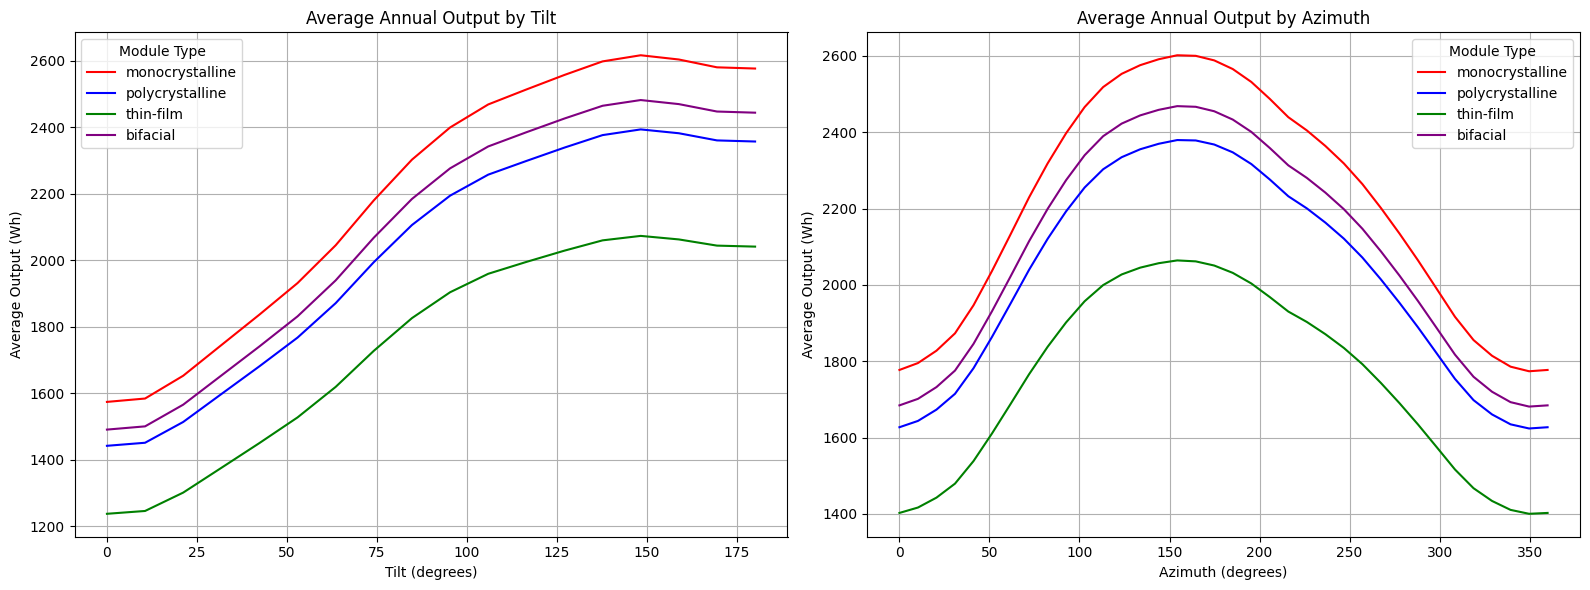

In [4]:
# Assume 'sa_results' is your DataFrame containing the results of the sensitivity analysis
module_types = ['monocrystalline', 'polycrystalline', 'thin-film', 'bifacial']
colors = ['red', 'blue', 'green', 'purple']  # Different colors for each module type

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Tilt Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    tilt_agg = filtered_data.groupby('tilt')['output'].mean()
    axes[0].plot(tilt_agg.index, tilt_agg.values, label=f'{module_type}', color=color)
axes[0].set_title('Average Annual Output by Tilt')
axes[0].set_xlabel('Tilt (degrees)')
axes[0].set_ylabel('Average Output (Wh)')
axes[0].legend(title='Module Type')
axes[0].grid(True)

# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('azimuth')['output'].mean()
    axes[1].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[1].set_title('Average Annual Output by Azimuth')
axes[1].set_xlabel('Azimuth (degrees)')
axes[1].set_ylabel('Average Output (Wh)')
axes[1].legend(title='Module Type')
axes[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()



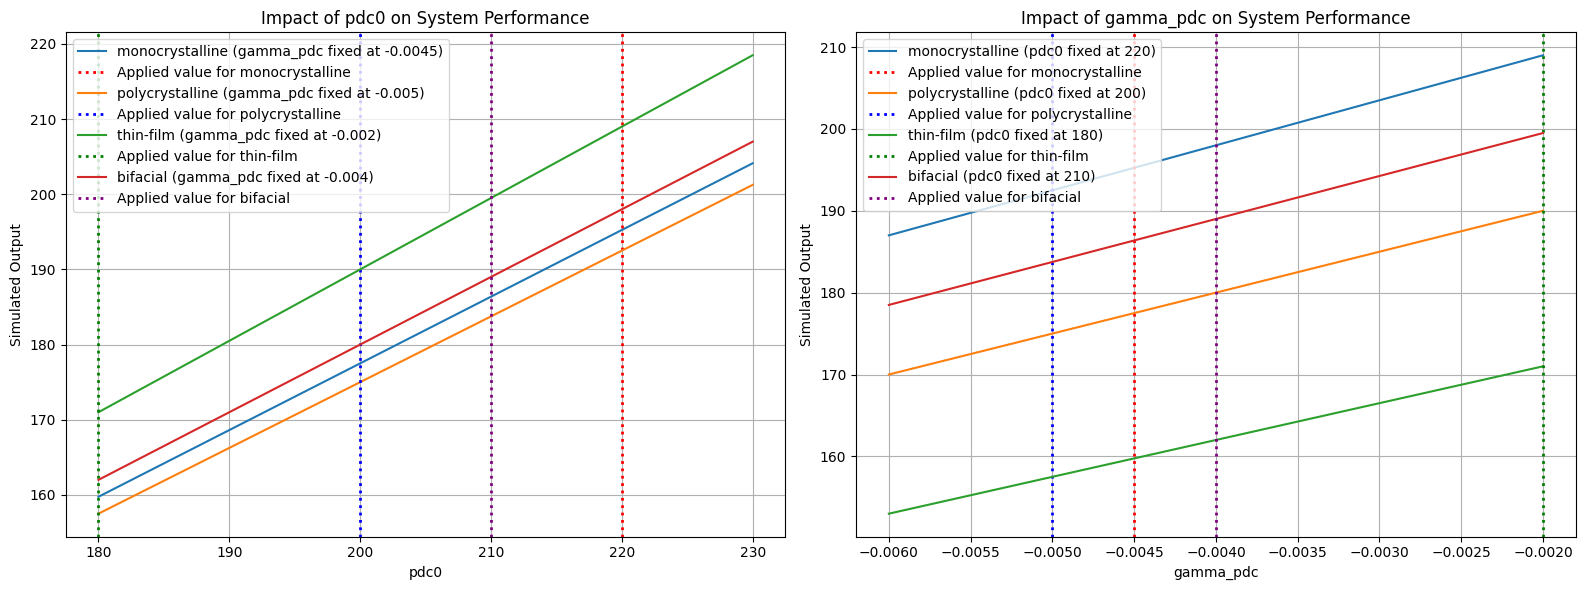

In [5]:

# Function to simulate system performance
def simulate_system_performance(pdc0, gamma_pdc, panel_type, tilt, azimuth):
    module_parameters = {'pdc0': pdc0, 'gamma_pdc': gamma_pdc}
    mount = pvsystem.FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)
    array = pvsystem.Array(mount=mount, module_parameters=module_parameters,
                           temperature_model_parameters=temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'],
                           module_type=panel_type)
    system = pvsystem.PVSystem(arrays=[array], inverter={'pdc0': 5000, 'eta_inv_nom': 0.96})
    # Simulate output
    simulated_output = pdc0 * (1 + gamma_pdc * 25)  # Simplified placeholder formula
    return simulated_output

# Define the range of values
pdc0_values = np.linspace(180, 230, 50)
gamma_pdc_values = np.linspace(-0.006, -0.002, 50)

# Fixed parameters for panel types
panel_specs = {
    'monocrystalline': {'pdc0': 220, 'gamma_pdc': -0.0045},
    'polycrystalline': {'pdc0': 200, 'gamma_pdc': -0.005},
    'thin-film': {'pdc0': 180, 'gamma_pdc': -0.002},
    'bifacial': {'pdc0': 210, 'gamma_pdc': -0.004}
}

# Sample tilt and azimuth for simulation
sample_tilt, sample_azimuth = 30, 180

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting for pdc0
for i, (ptype, specs) in enumerate(panel_specs.items()):
    outputs = [simulate_system_performance(pdc, specs['gamma_pdc'], ptype, sample_tilt, sample_azimuth) for pdc in pdc0_values]
    axes[0].plot(pdc0_values, outputs, label=f'{ptype} (gamma_pdc fixed at {specs["gamma_pdc"]})')
    axes[0].axvline(x=specs['pdc0'],  linestyle=':',color = colors[i], linewidth=2, label=f'Applied value for {ptype}')

axes[0].set_title('Impact of pdc0 on System Performance')
axes[0].set_xlabel('pdc0')
axes[0].set_ylabel('Simulated Output')
axes[0].legend()
axes[0].grid(True)

# Plotting for gamma_pdc)
for i, (ptype, specs) in enumerate(panel_specs.items()):
    outputs = [simulate_system_performance(specs['pdc0'], gamma, ptype, sample_tilt, sample_azimuth) for gamma in gamma_pdc_values]
    axes[1].plot(gamma_pdc_values, outputs, label=f'{ptype} (pdc0 fixed at {specs["pdc0"]})')
    axes[1].axvline(x=specs['gamma_pdc'],  linestyle=':',color = colors[i], linewidth=2, label=f'Applied value for {ptype}')

axes[1].set_title('Impact of gamma_pdc on System Performance')
axes[1].set_xlabel('gamma_pdc')
axes[1].set_ylabel('Simulated Output')
axes[1].legend()
axes[1].grid(True)

# Show plots
plt.tight_layout()
plt.show()


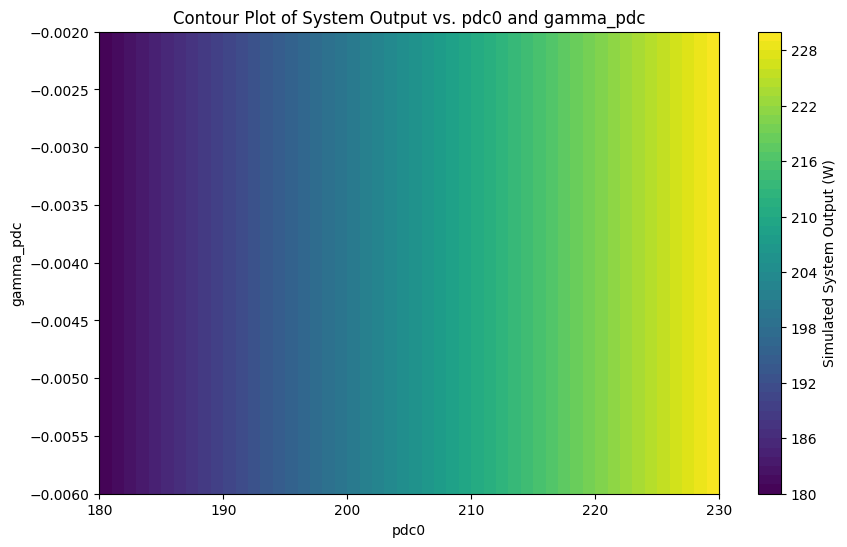

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Simplified simulation function
def simulate_system_performance(pdc0, gamma_pdc):
    # Assuming nominal operating conditions
    nominal_temperature = 25  # Nominal temperature in Celsius
    temperature_effect = gamma_pdc * (nominal_temperature - 25)  # Simplified temperature effect
    return pdc0 * (1 + temperature_effect)  

# Define the range of values for pdc0 and gamma_pdc
pdc0_values = np.linspace(180, 230, 50)
gamma_pdc_values = np.linspace(-0.006, -0.002, 50)

# Create a grid of pdc0 and gamma_pdc values
pdc0_grid, gamma_pdc_grid = np.meshgrid(pdc0_values, gamma_pdc_values)

# Compute simulated outputs over the grid
simulated_outputs = np.array([simulate_system_performance(pdc, gamma)
                              for pdc, gamma in zip(np.ravel(pdc0_grid), np.ravel(gamma_pdc_grid))])

# Reshape the results to fit the grid shape
simulated_outputs = simulated_outputs.reshape(pdc0_grid.shape)

# Plotting the contour plot
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(pdc0_grid, gamma_pdc_grid, simulated_outputs, levels=50, cmap=cm.viridis)
cbar = fig.colorbar(contour)
cbar.set_label('Simulated System Output (W)')
ax.set_title('Contour Plot of System Output vs. pdc0 and gamma_pdc')
ax.set_xlabel('pdc0')
ax.set_ylabel('gamma_pdc')
plt.show()
